In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from pandas_datareader import data as pdr_fred
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


Goal: 

Forecast daily returns of the S&P 500 index using a combination of technical indicators, macroeconomic data, and machine learning models. This helps explore how various data sources and model architectures can contribute to predicting short-term movements in financial markets.

Data Sources:

+ S&P 500 index: From Yahoo Finance (^GSPC, 2015–2025).

+ Macroeconomic data (from FRED):

    - GDP: Gross Domestic Product (quarterly)

    - UNRATE: Unemployment Rate (monthly)

    - UMCSENT: Consumer Sentiment Index (monthly)

The macro data was resampled to daily frequency and forward-filled to align with trading days

Feature Engineering: 

The input features include:

+ Lagged Returns: Previous 3 days of S&P 500 returns (Lag1, Lag2, Lag3)

+ Technical Indicators:

    - RSI (Relative Strength Index)

    - MACD (Moving Average Convergence Divergence)

    - ATR (Average True Range)

    - ADX (Average Directional Movement Index)

+ Macroeconomic Variables:

    - GDP, UNRATE, and UMCSENT (all aligned to the market calendar)

In [2]:
# 1. Download S&P 500 data
sp500 = yf.download('^GSPC', start='2015-01-01', end='2025-06-01', auto_adjust=True)
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.get_level_values(0)

# 2. Get macro data from FRED
start = sp500.index.min()
end = sp500.index.max()
fred_codes = {
    'GDP': 'GDP',
    'UNRATE': 'UNRATE',
    'UMCSENT': 'UMCSENT'
}
macro = pdr_fred.DataReader(list(fred_codes.values()), 'fred', start, end)
macro = macro.rename(columns={v: k for k, v in fred_codes.items()})
macro = macro.resample('D').ffill()
macro = macro.reindex(sp500.index).ffill().dropna()

# 3. Feature engineering
df = sp500.copy()
df['Return'] = df['Close'].pct_change()
df['Lag1'] = df['Return'].shift(1)
df['Lag2'] = df['Return'].shift(2)
df['Lag3'] = df['Return'].shift(3)

close_series = df['Close'].squeeze()
high_series = df['High'].squeeze()
low_series = df['Low'].squeeze()

# Technical indicators
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd_diff()
df['ATR'] = ta.volatility.AverageTrueRange(high=high_series, low=low_series, close=close_series).average_true_range()
df['ADX'] = ta.trend.ADXIndicator(high=high_series, low=low_series, close=close_series).adx()

# Add macro features
df = df.join(macro)
df = df.dropna()

# 4. Prepare features and target
features = ['Lag1','Lag2','Lag3','RSI','MACD','ATR','ADX','GDP','UNRATE','UMCSENT']
X_raw = df[features]
y = df['Return'].shift(-1).loc[X_raw.index]
X_raw = X_raw.iloc[:-1]
y = y.iloc[:-1]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=features, index=X_raw.index)



[*********************100%***********************]  1 of 1 completed


In [3]:
X_scaled.head()

,Lag1,Lag2,Lag3,RSI,MACD,ATR,ADX,GDP,UNRATE,UMCSENT
Date,,,,,,,,,,
2015-04-01,-0.803145,1.018597,0.164346,-0.883473,-0.226187,-0.854129,-0.912526,-1.261339,0.441668,0.943887
2015-04-02,-0.384581,-0.803629,1.019803,-0.699800,-0.206262,-0.870170,-0.978210,-1.261339,0.441668,0.943887
2015-04-06,0.264877,-0.385128,-0.803482,-0.368275,-0.115683,-0.843924,-1.082179,-1.261339,0.441668,0.943887
2015-04-07,0.531691,0.264234,-0.384738,-0.474990,-0.074080,-0.863697,-1.162637,-1.261339,0.441668,0.943887
2015-04-08,-0.219643,0.531008,0.265001,-0.334156,-0.016463,-0.882900,-1.255449,-1.261339,0.441668,0.943887


Models: 

Three models were trained and evaluated:

+ Linear Regression (LR) – A baseline linear model.

+ XGBoost – A gradient boosting model well-suited for structured/tabular data.

+ Recurrent Neural Network (RNN) using LSTM layers – Designed to capture temporal dependencies in sequential data.



Model evaluation:

+ Each model was trained on 80% of the data and tested on the remaining 20%. 

Performance metrics:

+ Mean Squared Error (MSE): Measures prediction error magnitude

+ Directional Accuracy (%): Measures how often the model correctly predicts whether the return is positive or negative

In [4]:
# Train-test split
split_index = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled.iloc[:split_index], X_scaled.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 5. Train models
lr = LinearRegression().fit(X_train, y_train)

# Grid search with time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.05, 0.1],
    'reg_alpha': [0, 0.05, 0.1],
    'reg_lambda': [0, 0.05, 0.1],
}
xgb_base = XGBRegressor(random_state=17)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
xgb = grid_search.best_estimator_
print("Best XGBoost parameters:", grid_search.best_params_)

# 6. RNN Setup
def create_rnn_input(X, window_size=10):
    X_seq = []
    for i in range(len(X) - window_size):
        X_seq.append(X.iloc[i:i+window_size].values)
    return np.array(X_seq)

window_size = 10
X_train_rnn = create_rnn_input(X_train, window_size)
y_train_rnn = y_train[window_size:].values
X_test_rnn = create_rnn_input(X_test, window_size)
y_test_rnn = y_test[window_size:].values

rnn = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
rnn.compile(loss='mse', optimizer='adam')
rnn.fit(X_train_rnn, y_train_rnn, epochs=60, batch_size=32, verbose=0)

# 7. Predictions
pred_lr = lr.predict(X_test)
pred_xgb = xgb.predict(X_test)
pred_rnn = rnn.predict(X_test_rnn).flatten()

# Align indices for comparison
y_test_cut = y_test.iloc[window_size:]
pred_lr_cut = pred_lr[window_size:]
pred_xgb_cut = pred_xgb[window_size:]

# 8. Evaluation
mse_lr = mean_squared_error(y_test_cut, pred_lr_cut)
mse_xgb = mean_squared_error(y_test_cut, pred_xgb_cut)
mse_rnn = mean_squared_error(y_test_cut, pred_rnn)

acc_lr = accuracy_score(y_test_cut > 0, pred_lr_cut > 0)
acc_xgb = accuracy_score(y_test_cut > 0, pred_xgb_cut > 0)
acc_rnn = accuracy_score(y_test_cut > 0, pred_rnn > 0)

print("Model Performance:")
print(f"LR:  MSE={mse_lr:.6f}, Acc={acc_lr:.2%}")
print(f"XGB: MSE={mse_xgb:.6f}, Acc={acc_xgb:.2%}")
print(f"RNN: MSE={mse_rnn:.6f}, Acc={acc_rnn:.2%}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.05}


c:\Users\edgar\miniconda3\envs\primary\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model Performance:
LR:  MSE=0.000104, Acc=54.58%
XGB: MSE=0.000105, Acc=56.18%
RNN: MSE=0.000119, Acc=48.80%


+ Linear Regression and XGBoost reasonably track the direction of returns with limited magnitude.

+ RNN predictions fail to react to market spikes or volatility. Some possible reasons:

    - Limited training epochs

    - Simple architecture 

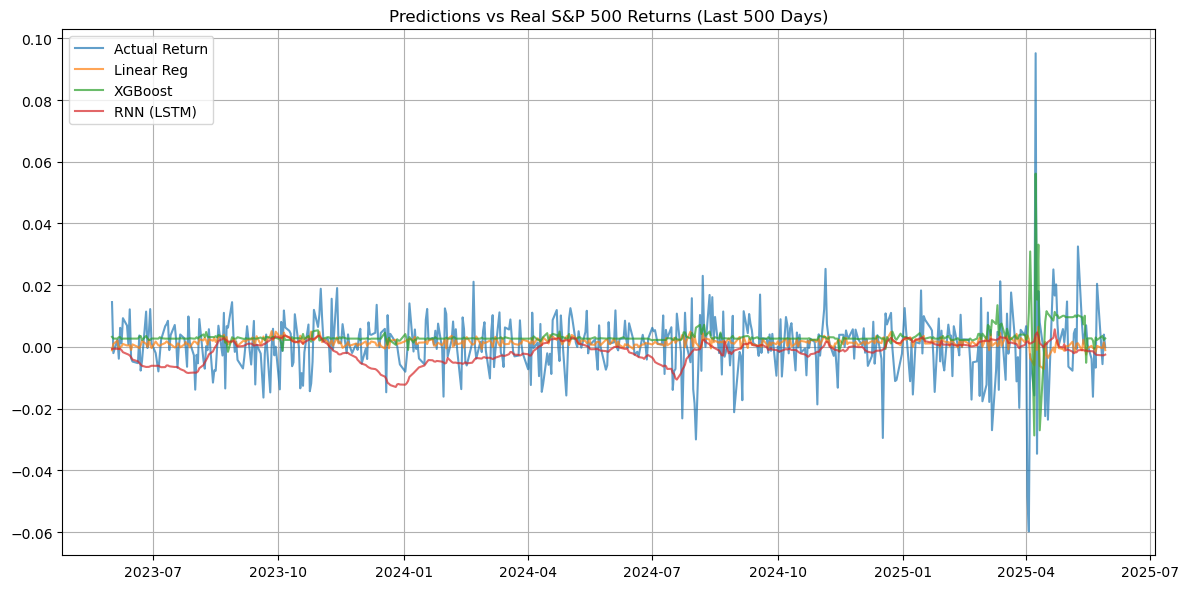

In [5]:
# 9. Plot predictions (last 500 days)
window = 500
index = y_test_cut.index[-window:]

plt.figure(figsize=(12, 6))
plt.plot(index, y_test_cut[-window:], label='Actual Return', alpha=0.7)
plt.plot(index, pred_lr_cut[-window:], label='Linear Reg', alpha=0.7)
plt.plot(index, pred_xgb_cut[-window:], label='XGBoost', alpha=0.7)
plt.plot(index, pred_rnn[-window:], label='RNN (LSTM)', alpha=0.7)
plt.legend()
plt.title("Predictions vs Real S&P 500 Returns (Last 500 Days)")
plt.grid(True)
plt.tight_layout()
plt.show()


Conclusions: 

+ Linear models offer surprisingly good baseline performance.

+ XGBoost marginally improves over linear regression but may require tuning to beat it.

+ RNN (LSTM) underperforms, likely due to insufficient sequence modeling or lack of deeper architecture.

Future directions:

+ Use rolling windows for realistic retraining and validation

+ Tuning the LSTM architecture